In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [57]:
card_img = cv.imread("./card.png")[:,:,::-1]

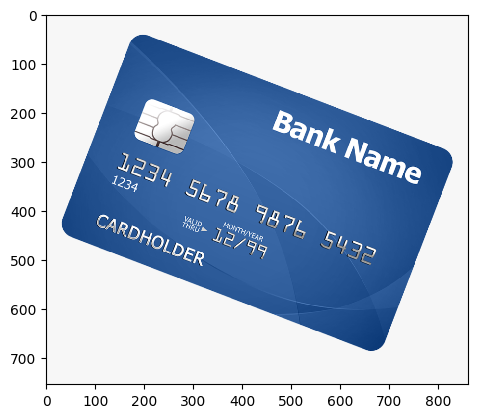

In [58]:
plt.imshow(card_img, interpolation = 'none')

In [59]:
card_gray = cv.cvtColor(card_img, cv.COLOR_BGR2GRAY)
ret, card_bin = cv.threshold(card_gray, 0, 255,cv.THRESH_BINARY+cv.THRESH_OTSU)

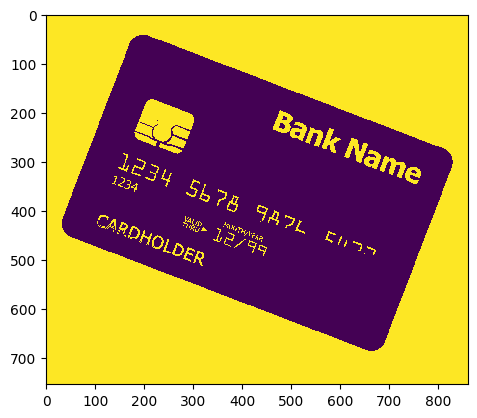

In [60]:
plt.imshow(card_bin, interpolation = 'none')

In [61]:
cmpts = cv.connectedComponentsWithStats( card_bin )

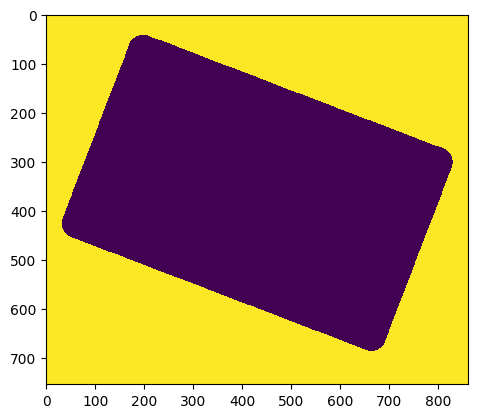

In [62]:
plt.imshow(cmpts[1] == 1, interpolation = 'none')

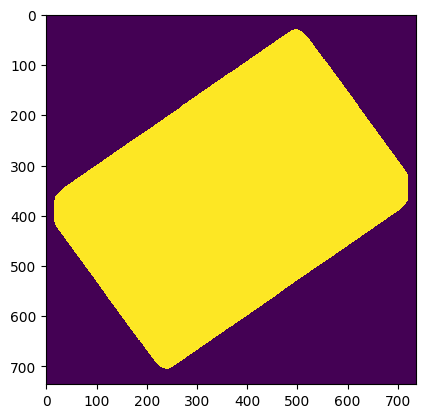

In [149]:
card_mask_1 = 1 - np.array(cmpts[1] == 1).astype(np.uint8).copy()
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,7) )
new = cv.dilate(card_mask_1, kernel, iterations = 10)
plt.imshow( new, interpolation = 'none'  );

In [10]:
def findborderblack(onedarr):
    black_idxs = np.where(onedarr != 0)[0]
    return black_idxs[0], black_idxs[-1]

In [63]:
card_mask = 1 - np.array(cmpts[1] == 1).astype(np.int8)
x_min, x_max = findborderblack(card_mask.sum(axis = 0, keepdims = False))
x_min, x_max

(np.int64(32), np.int64(828))

In [64]:
y_x_min, _ = findborderblack(card_mask[:, x_min])
y_x_max, _ = findborderblack(card_mask[:, x_max])

In [65]:
y_min, y_max = findborderblack(card_mask.sum(axis = 1, keepdims = False))
y_min, y_max

(np.int64(42), np.int64(685))

In [66]:
x_y_min, _ = findborderblack(card_mask[y_min, :])
x_y_max, _ = findborderblack(card_mask[y_max, :])

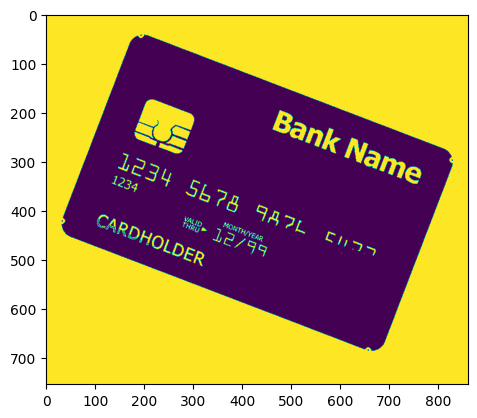

In [67]:
test_img = card_bin.copy()
cv.circle(test_img, (x_min,y_x_min), radius=4, color=255, thickness=4)
cv.circle(test_img, (x_max,y_x_max), radius=4, color=255, thickness=4)
cv.circle(test_img, (x_y_min,y_min), radius=4, color=255, thickness=4)
cv.circle(test_img, (x_y_max,y_max), radius=4, color=255, thickness=4)
plt.imshow( test_img )

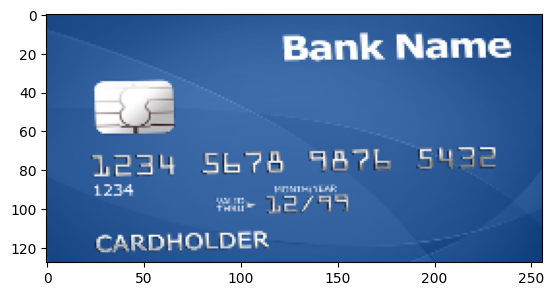

In [68]:
source_pts = np.zeros((4, 2))
orientation = abs(x_y_min - x_max) > abs(x_y_min - x_min)
source_pts[0] = [x_y_min,y_min] if orientation else [x_min,y_x_min]
source_pts[1] = [x_max,y_x_max] if orientation else [x_y_min,y_min]
source_pts[2] = [x_y_max,y_max] if orientation else [x_max,y_x_max]
source_pts[3] = [x_min,y_x_min] if orientation else [x_y_max,y_max]
source_pts = source_pts.astype(np.float32)

target_pts = np.float32([[0,0],\
             [256,0],\
             [256,128],\
             [0,128]])
M = cv.getPerspectiveTransform(source_pts, target_pts)
card_cropped = cv.warpPerspective(card_img, M, (256,128))
plt.imshow( card_cropped )

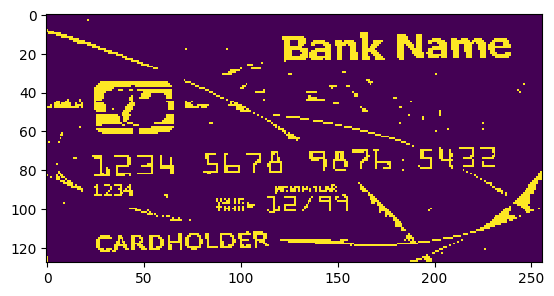

In [95]:
roi_gray = cv.cvtColor(card_cropped, cv.COLOR_BGR2GRAY)
roi_bin = cv.ximgproc.niBlackThreshold(roi_gray, 255, cv.THRESH_BINARY, 13, 0.5, cv.ximgproc.BINARIZATION_SAUVOLA  )
plt.imshow( roi_bin, interpolation = 'none' )

(array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  21,  22,  30,
        35,  36,  38,  39,  40,  42,  52,  53,  67,  68,  69,  70,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  99, 103, 109, 113, 114, 118, 122, 124, 127, 128, 130,
       138, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 169]),)


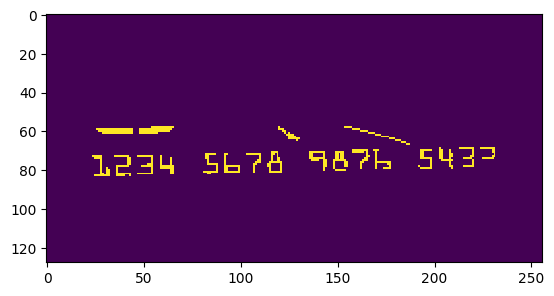

In [142]:
cmpts = cv.connectedComponentsWithStats( roi_bin )
sqrs = []
for pa in cmpts[2]:
    sqrs.append( pa[-1] )
sqrs = np.array( sqrs )
# sqrs = sqrs[sqrs < 5000]
# sqrs = sqrs[sqrs > 20]

print(np.where(sqrs > 15))
test = np.zeros(roi_bin.shape)
idxs = [i for i in range(67, 71)] + [i for i in range(79, 95)]
for i in idxs:
    test += cmpts[1] == i
plt.imshow(test, interpolation = 'none')